# 1. 加载数据集

In [2]:
from torchvision.datasets import mnist
from torchvision import transforms
from torch.utils.data import DataLoader

# 数据处理
data_transform = transforms.Compose([
    transforms.Resize(32), # 与LeNet网络输入一致
    transforms.ToTensor(), # 数据转化为tensor格式
    transforms.Normalize(mean=[0.5], std=[0.5]) # 规范化
])
batch_size = 256
# 加载训练数据集
train_dataset = mnist.MNIST(root='./data', train=True, transform=data_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# 加载测试数据集
test_dataset = mnist.MNIST(root='./data', train=False, transform=data_transform, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

E:\anaconda\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. 搭建模型

In [3]:
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 卷积层1 6个1*5*5的卷积核, 步长为1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        # 池化层1 2*2, 步长为2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 卷积层2 16个6*5*5的卷积核, 步长为1
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # 池化层2 2*2, 步长为2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全连接层1 使用卷积实现 120个16*5*5的卷积核, 步长为1
        self.fn1 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.flatten = nn.Flatten()
        # 全连接层2
        self.fn2 = nn.Linear(in_features=120, out_features=84)
        # 全连接层3
        self.fn3 = nn.Linear(in_features=84, out_features=10)
        # 激活函数
        self.relu = nn.ReLU()

    def forward(self, x):
        # C1: 卷积层1+激活函数 [B, 1, 32, 32] -> [B, 6, 28, 28]
        x = self.relu(self.conv1(x))
        # S2: 池化层1 [B, 6, 28, 28]-> [B, 6, 14, 14]
        x = self.pool1(x)
        # C3: 卷积层2+激活函数 [B, 6, 14, 14]-> [B, 16, 10, 10]
        x = self.relu(self.conv2(x))
        # S4: 池化层2 [B, 16, 10, 10]-> [B, 16, 5, 5]
        x = self.pool1(x)
        # c5: 全连接层1 [B, 16, 5, 5] -> [B, 120]
        x = self.flatten(self.fn1(x))
        # F6: 全连接层2 [B, 120] -> [B, 84]
        x = self.fn2(x)
        # output10: [B, 84] -> [B, 10]
        output = self.fn3(x)
        return output

# 3. 训练与保存

In [5]:
import torch
import numpy as np
# 使用GPU加速
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def train(dataloader, model, loss_fn, optimizer):
    '''
    :param dataloader: 训练数据
    :param model: 训练模型
    :param loss_fn: 损失函数
    :param optimizer: 优化器
    '''
    model.train() # 训练模式
    loss_sum = 0.0
    all_correct_num = 0
    all_sample_num = 0
    for idx, (data, label) in enumerate(dataloader):
        data, label = data.to(device), label.to(device) # 在GPU上计算
        predict_data = model(data) # 预测 前向计算
        # 反向传播
        optimizer.zero_grad() # 梯度清零
        loss = loss_fn(predict_data, label) # 计算损失
        loss_sum += loss.item()
        loss.backward() # 计算梯度
        optimizer.step() # 梯度更新
        predict_label = torch.argmax(predict_data, dim=-1) # 计算预测label
        all_correct_num += np.sum((predict_label == label).to('cpu').numpy(), axis=-1)
        all_sample_num += label.shape[0]
    avg_acc = all_correct_num / all_sample_num
    avg_loss = loss_sum / all_sample_num
    print('train_loss: {:.8f}'.format(avg_loss) + '     train_acc: {:.3f}'.format(avg_acc))

In [4]:
def val(dataloader, model, loss_fn):
    '''
    :param dataloader: 测试数据
    :param model: 模型
    :param loss_fn: 损失函数
    '''
    model.eval() # 测试模式
    loss_sum = 0.0
    all_correct_num = 0
    all_sample_num = 0
    # 不计算梯度 节约计算开销
    with torch.no_grad():
        for idx, (data, label) in enumerate(dataloader):
            data, label = data.to(device), label.to(device) # 在GPU上计算
            predict_data = model(data) # 预测 前向计算
            loss = loss_fn(predict_data, label) # 计算损失
            loss_sum += loss.item()
            predict_label = torch.argmax(predict_data, dim=-1) # 计算预测label
            all_correct_num += np.sum((predict_label == label).to('cpu').numpy(), axis=-1)
            all_sample_num += label.shape[0]
        avg_acc = all_correct_num / all_sample_num
        avg_loss = loss_sum / all_sample_num
        print('val_loss: {:.8f}'.format(avg_loss) + '     val_acc: {:.3f}'.format(avg_acc))
    return avg_acc

In [5]:
loss_fn = torch.nn.CrossEntropyLoss() # 使用交叉熵损失函数
epoch = 20 # 训练总轮次
model = LeNet5() # 创建LeNet5
model.to(device)
from torch.optim import SGD
sgd = SGD(model.parameters(), lr=1e-1) # 优化器
best_acc = 0.0
print("start train model")
for e in range(epoch):
    print(f'\nepoch {e+1}\n----------------------------------------------------')
    train(train_dataloader, model, loss_fn, sgd)
    val_acc = val(test_dataloader, model, loss_fn)
    # 保存最好的模型参数
    if val_acc > best_acc:
        best_acc = val_acc
        import os
        if not os.path.isdir("models"):
            os.mkdir("models")
        print("save best model")
        torch.save(model.state_dict(), 'models/mnist.pkt')
print(f'the best acc on testdata: {best_acc}')
print("done")

start train model

epoch 1
----------------------------------------------------
train_loss: 0.00242678     train_acc: 0.806
val_loss: 0.00062634     val_acc: 0.953
save best model

epoch 2
----------------------------------------------------
train_loss: 0.00048715     train_acc: 0.962
val_loss: 0.00041505     val_acc: 0.966
save best model

epoch 3
----------------------------------------------------
train_loss: 0.00034465     train_acc: 0.973
val_loss: 0.00030628     val_acc: 0.976
save best model

epoch 4
----------------------------------------------------
train_loss: 0.00028462     train_acc: 0.978
val_loss: 0.00022368     val_acc: 0.982
save best model

epoch 5
----------------------------------------------------
train_loss: 0.00024397     train_acc: 0.981
val_loss: 0.00022966     val_acc: 0.981

epoch 6
----------------------------------------------------
train_loss: 0.00021346     train_acc: 0.983
val_loss: 0.00026555     val_acc: 0.978

epoch 7
---------------------------------

# 4. 测试

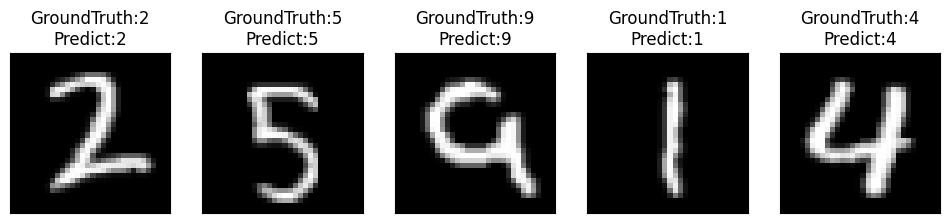

In [7]:
# 加载训练完成的模型权重
model = LeNet5() # 创建LeNet5
model.to(device)
model.load_state_dict(torch.load('models/mnist.pkt'))
import matplotlib.pyplot as plt
_, (image, label) = next(enumerate(test_dataloader))
image = image.to(device)
model.eval()
prediction = model(image).detach().cpu().numpy()
image = image.to('cpu')
pred_label = np.argmax(prediction, axis=-1)
f, ax = plt.subplots(1, 5, figsize=(12, 8))
for i in range(5):
    ax[i % 5].imshow(image[i][0], cmap='gray')
    ax[i % 5].set_title(f'GroundTruth:{label[i]}\nPredict:{pred_label[i]}')
    ax[i % 5].set_xticks([])
    ax[i % 5].set_yticks([])
plt.show()